In [17]:
import pandas_datareader as pdr

In [18]:
df=pdr.get_data_tiingo('AAPL', api_key='8e655c68622c85219d94fc2a3e4cfc3db2750f52')

c:\Users\Promi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas_datareader\tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  return pd.concat(dfs, self._concat_axis)


In [19]:
df.to_csv('AAPL.csv')

In [20]:
import pandas as pd

In [21]:
df=pd.read_csv('AAPL.csv')

In [22]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,AAPL,2023-01-13 00:00:00+00:00,134.76,134.92,131.66,132.030,57809719,134.76,134.92,131.66,132.030,57809719,0.0,1.0
1254,AAPL,2023-01-17 00:00:00+00:00,135.94,137.29,134.13,134.830,63646627,135.94,137.29,134.13,134.830,63646627,0.0,1.0
1255,AAPL,2023-01-18 00:00:00+00:00,135.21,138.61,135.03,136.815,69672800,135.21,138.61,135.03,136.815,69672800,0.0,1.0
1256,AAPL,2023-01-19 00:00:00+00:00,135.27,136.25,133.77,134.080,58280413,135.27,136.25,133.77,134.080,58280413,0.0,1.0
1257,AAPL,2023-01-20 00:00:00+00:00,137.87,138.02,134.22,135.280,80223626,137.87,138.02,134.22,135.280,80223626,0.0,1.0


In [23]:
df1=df.reset_index()['close']

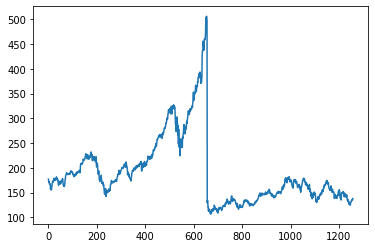

In [24]:
import matplotlib.pyplot as plt
plt.plot(df1)

# LSTM are sensitive to the scale of the data , so we apply MinMaxScaler

In [25]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [26]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data, test_data = df1[0:training_size], df1[training_size:len(df1), :1]

In [27]:
len(train_data), len(test_data)

(817, 441)

In [28]:
def create_dataset(dataset, time_step=1):
    dataX, dataY=[], []
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [29]:
time_step =100
X_train, y_train=create_dataset(train_data, time_step)
X_test, ytest=create_dataset(test_data, time_step)

In [30]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [31]:
model=Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.fit(X_train, y_train, validation_data=(X_test, ytest), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
12/12 [==============================] - 6s 188ms/step - loss: 0.0317 - val_loss: 6.3383e-04
Epoch 2/100
12/12 [==============================] - 1s 123ms/step - loss: 0.0203 - val_loss: 0.0080
Epoch 3/100
12/12 [==============================] - 1s 115ms/step - loss: 0.0131 - val_loss: 0.0014
Epoch 4/100
12/12 [==============================] - 1s 116ms/step - loss: 0.0102 - val_loss: 6.2863e-04
Epoch 5/100
12/12 [==============================] - 1s 112ms/step - loss: 0.0116 - val_loss: 0.0019
Epoch 6/100
12/12 [==============================] - 1s 114ms/step - loss: 0.0084 - val_loss: 3.9115e-04
Epoch 7/100
12/12 [==============================] - 1s 115ms/step - loss: 0.0083 - val_loss: 7.6218e-04
Epoch 8/100
12/12 [==============================] - 1s 112ms/step - loss: 0.0071 - val_loss: 3.2412e-04
Epoch 9/100
12/12 [==============================] - 1s 116ms/step - loss: 0.0065 - val_loss: 3.6381e-04
Epoch 10/100
12/12 [==============================] - 1s 113ms/step

In [33]:
import tensorflow as tf
tf.__version__

'2.11.0'

In [34]:
### Lets do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 22ms/step


In [35]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

0.04560360377322333

In [36]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest, test_predict))

0.022122250990495237

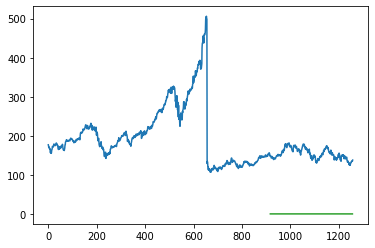

In [37]:
# Shift train predictions for plotting
look_back = 100
trainPredictPlot=np.empty_like(df1)
trainPredictPlot[:, :]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :]
# Shift test predictions for plotting
testPredictPlot=np.empty_like(df1)
testPredictPlot[:, :]=np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# Plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [38]:
len(test_data)
x_input = test_data[341:].reshape(1, -1)
x_input.shape

(1, 100)

In [39]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [40]:
# Demonstrate prediction for next 10 days
from numpy import array
lst_output=[]
n_steps=100
i=0
while(i<30):
    if (len(temp_input)>100):
        # print (temp_input)
        X_input = np.array(temp_input[1:])
        print("{}dayinput{}".format(i,x_input))
        X_input=X_input.reshape(1, -1)
        X_input=X_input.reshape((1, n_steps, 1))
        # print(X_input)
        yhat=model.predict(X_input, verbose=0)
        print("{} day output{}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input=x_input.reshape(1, n_steps, 1)
        yhat=model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
        
print(lst_output)        



[0.08357587]
101
1dayinput[[[0.13660614]
  [0.13041954]
  [0.1261866 ]
  [0.12804008]
  [0.12265498]
  [0.11944897]
  [0.12303068]
  [0.11927364]
  [0.1265623 ]
  [0.14174076]
  [0.11772073]
  [0.12140263]
  [0.11403882]
  [0.10985598]
  [0.11932373]
  [0.1253851 ]
  [0.11742016]
  [0.11496556]
  [0.10917971]
  [0.11003131]
  [0.11251096]
  [0.10770194]
  [0.08926738]
  [0.07854728]
  [0.08919224]
  [0.09833438]
  [0.09908579]
  [0.09665623]
  [0.08328115]
  [0.0841077 ]
  [0.08050094]
  [0.07889793]
  [0.09054477]
  [0.07899812]
  [0.08909205]
  [0.09244834]
  [0.09272386]
  [0.09154665]
  [0.10126487]
  [0.10672511]
  [0.11396368]
  [0.10647464]
  [0.09507827]
  [0.12247965]
  [0.11646838]
  [0.10973075]
  [0.09565435]
  [0.08025047]
  [0.07899812]
  [0.08035066]
  [0.08180338]
  [0.07020664]
  [0.10026299]
  [0.10735128]
  [0.10379461]
  [0.10820288]
  [0.10507201]
  [0.10990607]
  [0.11133375]
  [0.10311835]
  [0.10855354]
  [0.11078272]
  [0.10336882]
  [0.09362555]
  [0.08598622]

In [41]:
day_new=np.arange(1,101)
day_pred=np.arange(101, 131)
len(df1)

1258

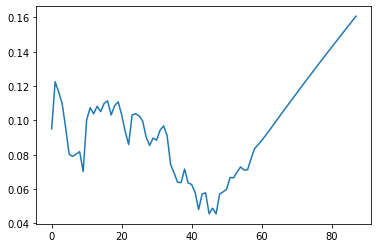

In [42]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

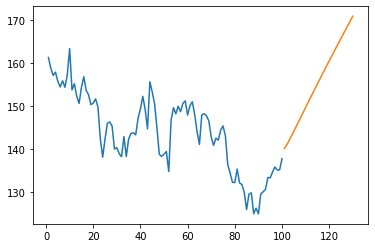

In [43]:
plt.plot(day_new, scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))